<a href="https://colab.research.google.com/github/machadoprx/CoolConvNN/blob/master/cora_link_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download CORA dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
!tar -xzvf cora.tgz

--2021-03-10 23:40:57--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘cora.tgz.1’

cora.tgz.1          100%[===================>] 164.11K   357KB/s    in 0.5s    

2021-03-10 23:40:58 (357 KB/s) - ‘cora.tgz.1’ saved [168052/168052]

cora/
cora/README
cora/cora.cites
cora/cora.content


In [3]:
import os
import networkx as nx
import pandas as pd

data_dir = os.path.expanduser("./cora")
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
edgelist.sample(frac=1).head(5)

,target,source,label
713,3095,110162,cites
4890,444191,1154068,cites
2557,27627,18619,cites
2353,22431,6639,cites
621,2654,1123926,cites


In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

In [5]:
subjects = {'Case_Based':[1,0,0,0,0,0,0],
    'Genetic_Algorithms':[0,1,0,0,0,0,0],
    'Neural_Networks':[0,0,1,0,0,0,0],
    'Probabilistic_Methods':[0,0,0,1,0,0,0],
    'Reinforcement_Learning':[0,0,0,0,1,0,0],
    'Rule_Learning':[0,0,0,0,0,1,0],
    'Theory':[0,0,0,0,0,0,1]}
color = {'Case_Based':'r',
    'Genetic_Algorithms':'g',
    'Neural_Networks':'b',
    'Probabilistic_Methods':'y',
    'Reinforcement_Learning':'c',
    'Rule_Learning':'m',
    'Theory':'k'}

In [6]:
print(node_data.head())

         w_0  w_1  w_2  w_3  ...  w_1430  w_1431  w_1432                 subject
31336      0    0    0    0  ...       0       0       0         Neural_Networks
1061127    0    0    0    0  ...       0       0       0           Rule_Learning
1106406    0    0    0    0  ...       0       0       0  Reinforcement_Learning
13195      0    0    0    0  ...       0       0       0  Reinforcement_Learning
37879      0    0    0    0  ...       0       0       0   Probabilistic_Methods

[5 rows x 1434 columns]


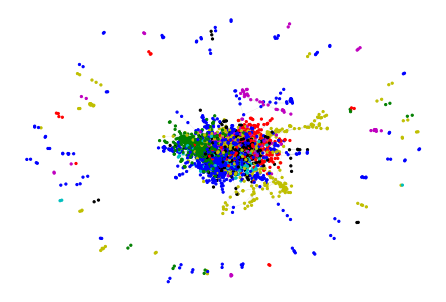

In [7]:
colors = []
for node in Gnx.nodes():
    colors.append(color[node_data.loc[node, 'subject']])
nx.draw(Gnx, node_size=5, node_color=colors, style='dashed', width=0.05, edge_color='black')

In [8]:
import numpy as np
for node in Gnx.nodes():
    Gnx.nodes[node]['features'] = node_data.loc[node][:-1].to_numpy()
    Gnx.nodes[node]['subject'] = subjects[node_data.loc[node][-1]]

In [9]:
# S = α ⋅ (I − (1 − α) ⋅ A¯ )^-1
#A¯ = AD^-1

In [10]:
def normalized_adj(G):
    nodes = np.array([node for node in G.nodes()])
    A = np.zeros((len(nodes), len(nodes)))
    D = np.zeros((len(nodes), len(nodes)))
    for i in nodes:
        index_i = np.where(nodes == i)[0]
        for j in list(G[i].keys()):
            index_j = np.where(nodes == j)[0]
            A[index_i,index_j] = 1.
        D[index_i,index_i] = 1/len(list(G[i].keys()))
    #A = A + np.eye(A.shape[0])
    return np.matmul(A, D), nodes

def page_rank_intimacy(A, alpha=0.15):
    return np.linalg.matrix_power(alpha*(np.eye(A.shape[0])-(1-alpha)*A), -1)
A_norm, nodes = normalized_adj(Gnx)
S = page_rank_intimacy(A_norm)

In [11]:
print(S)

[[7.86045461e+00 8.87442583e-02 2.30076178e-02 ... 4.31155233e-03
  5.69468765e-03 3.20559506e-03]
 [2.98180708e+00 1.03786125e+01 2.61893401e+00 ... 7.30311666e-02
  8.09538135e-02 1.00814637e-01]
 [2.76091414e-02 9.35333574e-02 9.28463452e+00 ... 1.19267444e-02
  1.52718506e-02 1.03103039e-02]
 ...
 [3.44924186e-03 1.73883730e-03 7.95116290e-03 ... 1.03473590e+01
  3.98022085e+00 5.38024277e+00]
 [4.55575012e-03 1.92747175e-03 1.01812337e-02 ... 3.98022085e+00
  9.21795062e+00 2.07316276e+00]
 [1.28223802e-03 1.20017426e-03 3.43676798e-03 ... 2.69012139e+00
  1.03658138e+00 9.54965062e+00]]


In [12]:
import random

def get_dataset(G, S, nodes, neighbor_sample=6):
    X1 = []
    y = []
    for node in nodes:
        index_i = np.where(nodes == node)[0][0]
        s_row = []
        for s, k in zip(S[index_i], nodes):
            s_row.append((s, k))
        s_row = sorted(s_row, key=lambda a: a[0], reverse=True)[:neighbor_sample]
        for i in range(len(s_row)):
            if s_row[i][0] == 0.0:
                s_row[i] = s_row[0]
        print(node, s_row)
        neighborhood = [k for _, k in s_row]
        f_neighbors = [G.nodes[h]['features'] for h in neighborhood]
        X1.append(np.array(f_neighbors))
        y.append(G.nodes[node]['subject'])
    return np.array(X1, dtype=np.float), np.array(y)

seq_size=8
X, y = get_dataset(Gnx, S, nodes, neighbor_sample=seq_size)
#X = (X-np.mean(X, axis=0))/(np.std(X, axis=0)+1e-5)

1033 [(7.860454608012506, 1033), (2.729596010798091, 1107062), (2.428974201828443, 1034), (1.4308946067433046, 1153945), (1.2012809798104693, 1035), (0.9617921975386065, 45605), (0.9378366375675667, 1026), (0.8131753394745387, 41714)]
35 [(10.378612498410515, 35), (8.821820623648943, 1152508), (8.821820623648941, 1128945), (8.821820623648941, 1137466), (7.67114836839038, 577227), (7.671148368390379, 1131752), (7.671148368390377, 594900), (7.671148368390376, 574009)]
103482 [(9.2846345158904, 103482), (5.00751390133785, 1128990), (4.681845976796054, 27514), (3.200792024379156, 1114388), (2.9983366590741753, 1119140), (2.4977511343163017, 27510), (1.8376583693976867, 260979), (1.7314736648061952, 1152143)]
103515 [(8.679250600284442, 103515), (4.839567260840378, 1113742), (3.3917205783481306, 575402), (3.3194822652001297, 1128314), (2.8215599254201105, 579108), (2.7322669199100305, 1129778), (2.707966484045859, 246618), (2.3763697441569587, 459214)]
1050679 [(7.1480390623534, 1050679), (

In [13]:
print(X.shape)

(2708, 8, 1433)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.9, random_state=42, shuffle=True)

In [15]:
print('Train samples:', X_train.shape[0])
print('Validation samples:', X_val.shape[0])
print('Test samples:', X_test.shape[0])

Train samples: 167
Validation samples: 1511
Test samples: 1030


In [16]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
from tensorflow.keras import initializers, regularizers, constraints
import tensorflow as tf

class CustomMultiHeadAttention(tf.keras.layers.MultiHeadAttention):

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(tf.keras.layers.MultiHeadAttention, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output, tf.math.reduce_mean(query, 2), tf.math.reduce_mean(key, 2), tf.math.reduce_mean(value, 2)

# Node encoding using Transformer

For node encoding, first we select the representative nodes for each node by a measure of intimacy as in [GRAPH-BERT: Only Attention is Needed for Learning Graph Representations], but including each node representation in the sequence

In [82]:
from tensorflow.keras import layers
from tensorflow.keras import constraints
from tensorflow.keras.constraints import max_norm
 
class TransformerEncodeBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.5):
        super(TransformerEncodeBlock, self).__init__()
        self.att = CustomMultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(embed_dim, activation='relu'),layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
 
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output2 = self.dropout1(attn_output[0], training=training)
        out1 = self.layernorm1(inputs + attn_output2)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output), attn_output[1], attn_output[2], attn_output[3]

class TransformerDecodeBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.5):
        super(TransformerDecodeBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(embed_dim, activation='relu'),layers.Dense(embed_dim) ,]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
 
    def call(self, inputs, training):
        attn_output = self.att(inputs[0], inputs[0])
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output) # Use key, value outputs

        # encoder-decoder attention (use key and value output from the encoder stack)
        enc_dec_att_out = self.att2(out1, inputs[1], inputs[2])
        enc_dec_att_out = self.layernorm3(enc_dec_att_out+out1)

        ffn_output = self.ffn(enc_dec_att_out)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def attention_model(in_dim=128,embed_dim=512, seq_size=2, out_emb=2048, ff_dim=2048, kernel_constraint=2, n_heads=8, lr=5e-5, rate=0.5, l2_reg=1e-3):
 
    inp = layers.Input(shape=(seq_size, in_dim))

    transformer_block_1 = TransformerEncodeBlock(embed_dim, n_heads, rate=rate)
    transformer_block_2 = TransformerEncodeBlock(embed_dim, n_heads, rate=rate)
    transformer_block_3 = TransformerEncodeBlock(embed_dim, n_heads, rate=rate)
    
    transformer_block_4 = TransformerDecodeBlock(embed_dim, n_heads, rate=rate)
    transformer_block_5 = TransformerDecodeBlock(embed_dim, n_heads, rate=rate)
    transformer_block_6 = TransformerDecodeBlock(embed_dim, n_heads, rate=rate)

    ff_in = layers.Dense(ff_dim, activation='relu')(inp)
    ff_in = layers.Dense(ff_dim, activation='relu')(ff_in)

    z = layers.Dense(embed_dim)(ff_in)
    
    '''z, _, _, _ = transformer_block_1(z)
    z, _, _, _ = transformer_block_2(z)
    z, _, k_enc, v_enc = transformer_block_3(z)

    z = transformer_block_4([z, k_enc, v_enc])
    z = transformer_block_5([z, k_enc, v_enc])
    z = transformer_block_6([z, k_enc, v_enc])'''

    emb = layers.Dense(ff_dim, activation='relu')(z)
    emb = layers.GlobalAveragePooling1D()(emb)
    emb = layers.Dropout(rate)(emb)
    emb = layers.Dense(ff_dim, activation='relu')(emb)
    emb = layers.Dense(out_emb, activity_regularizer=tf.keras.regularizers.l2(l2_reg))(emb)
    
    attention = tf.keras.Model(inp, emb)
    
    classifier_in = layers.Input(shape=(out_emb))

    outputs = layers.Dense(7, activation="softmax")(classifier_in)
    classifier = tf.keras.Model(classifier_in, outputs)
 
    model = tf.keras.Model(inp, classifier(attention(inp)))
 
    opt = tf.keras.optimizers.Adamax(learning_rate=lr)
    model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy', f1_m],
                    run_eagerly=False)
    return model

In [85]:
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(0)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20,restore_best_weights=True, mode='max')
att_model = attention_model(in_dim=1433,embed_dim=1024, out_emb=1024, ff_dim=2048, seq_size=seq_size, n_heads=12, lr=1e-4, l2_reg=1e-4, rate=0.1)
#att_model.load_weights('/content/drive/My Drive/cora_att_model.md5')
att_model.fit(X_train, y_train,epochs=200, batch_size=32, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/200
6/6 [==============================] - 2s 133ms/step - loss: 1.8702 - accuracy: 0.2384 - f1_m: 0.0000e+00 - val_loss: 1.8781 - val_accuracy: 0.2952 - val_f1_m: 0.0051
Epoch 2/200
6/6 [==============================] - 0s 63ms/step - loss: 1.7832 - accuracy: 0.3099 - f1_m: 0.0227 - val_loss: 1.8305 - val_accuracy: 0.2952 - val_f1_m: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 0s 63ms/step - loss: 1.6426 - accuracy: 0.3537 - f1_m: 0.0262 - val_loss: 1.8169 - val_accuracy: 0.2952 - val_f1_m: 0.0360
Epoch 4/200
6/6 [==============================] - 0s 65ms/step - loss: 1.5613 - accuracy: 0.3899 - f1_m: 0.2158 - val_loss: 1.7588 - val_accuracy: 0.2952 - val_f1_m: 0.0432
Epoch 5/200
6/6 [==============================] - 0s 65ms/step - loss: 1.5300 - accuracy: 0.3968 - f1_m: 0.1467 - val_loss: 1.6905 - val_accuracy: 0.3958 - val_f1_m: 0.0162
Epoch 6/200
6/6 [==============================] - 0s 64ms/step - loss: 1.4421 - accuracy: 0.5230 - f1_m: 0.2057 - val_lo

In [86]:
att_model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 5ms/step - loss: 0.7443 - accuracy: 0.8000 - f1_m: 0.7636


[0.7442598342895508, 0.800000011920929, 0.7636415362358093]

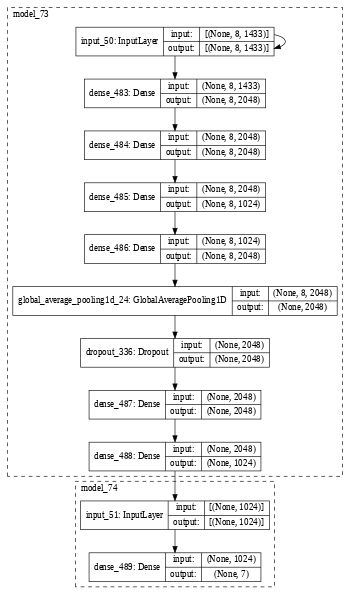

In [87]:
tf.keras.utils.plot_model(
    att_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=45,
)

In [88]:
intermediate_layer_model = tf.keras.models.Model(inputs=att_model.input,
                                 outputs=att_model.layers[1].output)
X_tf = intermediate_layer_model.predict(X)
X_tf = (X_tf-np.mean(X_tf, axis=0))/(1e-5+np.std(X_tf, axis=0))

In [89]:
print(list(X_tf[0]))

[-1.5219897, -1.8935142, 2.041726, 0.52961475, 1.716259, 0.33999276, 2.1851158, -1.1956028, -1.963204, 2.0544324, -1.679293, -1.4473746, 1.2383949, 0.38848287, -2.2423081, -0.33149165, 1.0366582, 2.070596, 2.2372243, -0.4599413, -0.5420718, -2.1771898, 0.5658134, -1.2849468, -1.3640653, 0.4848505, -0.5336605, -1.5603578, 1.0561589, 1.5108416, -1.8345255, 1.442725, 1.0461352, -1.5884086, 2.1389155, -1.9873362, 0.46713153, 1.1406904, -2.4608693, -1.7596532, 0.70747584, -0.50643474, -2.229727, -1.8021835, -1.4407204, -1.0427685, 0.7297103, -2.1875234, -2.1195765, -1.9430889, 1.0310341, -1.2641684, -0.9352334, 1.756251, -1.5615169, -0.15126258, -2.0159132, 0.6039337, 2.0934777, -2.2297113, -1.8403343, 1.2726192, -2.4745653, 2.2563667, 1.9385214, -1.5034375, -1.8354907, -2.2791219, -2.1531718, 1.6987238, -2.1921737, 1.2294085, -2.5071244, 2.5643039, 1.4361935, -1.2265077, -0.84196526, 2.3629868, 1.2459469, -0.8966226, 2.0625584, -1.3112442, 0.9210528, 1.3933127, 2.1398358, 0.4416263, -2.109

In [90]:
print(X_tf.shape)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='pca', perplexity=25.).fit_transform(X_tf)

(2708, 1024)


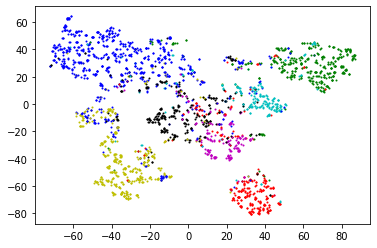

In [91]:
import matplotlib.pyplot as plt
color2 = {'0':'r',
    '1':'g',
    '2':'b',
    '3':'y',
    '4':'c',
    '5':'m',
    '6':'k'}
    
for i in range(len(y)):
    c = color2[str(np.argmax(y[i]))]
    plt.plot(X_embedded[i,0], X_embedded[i,1], f"{c}o", markersize=1)
plt.show()
#att_model.save_weights('/content/drive/My Drive/cora_att_model.md5')

## Build a new Graph matrix with the learned embeddings

In [92]:
def reconstruct_adj(X, k=100):
    n = X.shape[0]
    A = np.zeros((n, n))
    for i in range(n):
        dists = np.linalg.norm(np.array([X[i]]*n)-X, axis=1)
        dists = [(dists[j], j) for j in range(n)]
        dists = sorted(dists, key=lambda a:a[0])[:k]
        for _, j in dists:
            A[i,j] = 1.
    return A

#A = reconstruct_adj(X_tf)

In [93]:
import gc; gc.enable()
gc.collect()

205737